In [16]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import shutil
import projcore as pc
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
import math
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

sns.set(style="whitegrid")

In [17]:
source_dir = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')
IMG_DIR = os.path.join(os.getcwd(), 'images')

if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)
    print(f"Created directory: {IMG_DIR}")
else:
    print(f"Image directory already exists: {IMG_DIR}")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    pc.download_kaggle_datasets()
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.csv'):
            full_file_name = os.path.join(source_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, DATA_DIR)
                print(f"Moved: {full_file_name} to {DATA_DIR}")
else:
    print(f"Data directory already exists: {DATA_DIR}")

Image directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\images
Data directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\data


In [18]:
def load_data(data_dir=DATA_DIR):
    """Load all datasets."""
    battles_df = pd.read_csv(os.path.join(data_dir, 'BattlesStaging_01012021_WL_tagged.csv'))
    card_master_list = pd.read_csv(os.path.join(data_dir, 'CardMasterListSeason18_12082020.csv'))
    wincons = pd.read_csv(os.path.join(data_dir, 'Wincons.csv'))
    
    mapping = {
        'battles_df': battles_df,
        'card_master_list': card_master_list,
        'wincons': wincons
    }
    
    return mapping

In [20]:
# load the actual data
datasets_mapping = load_data()
battles_df = datasets_mapping['battles_df']
card_master_list = datasets_mapping['card_master_list']
wincons = datasets_mapping['wincons']

In [21]:
battles_df = pc.feature_preprocessing(battles_df, wincons)

In [22]:
high_win_rate_probability = battles_df['winner.high_win_rate'].mean()
k = 501 # adjustable parameter
sample_size = math.ceil(k / high_win_rate_probability)
print(f"High win rate probability: {high_win_rate_probability}")

High win rate probability: 0.24741492819344177


In [23]:
battles_df_sampled = battles_df.sample(n=sample_size, random_state=42).copy()
print(f"Number of battles after filtering: {battles_df_sampled.shape[0]}")

battles_df_sampled.head()

Number of battles after filtering: 2025


battleTime    arena.id  gameMode.id  \
192749  2021-01-01 02:18:26+00:00  54000050.0          0.0   
967227  2021-01-01 15:29:24+00:00  54000050.0          1.0   
1547634 2021-01-01 00:37:40+00:00  54000050.0          0.0   
575827  2021-01-01 08:57:46+00:00  54000050.0          1.0   
2783037 2021-01-01 22:21:28+00:00  54000050.0          1.0   

         average.startingTrophies  winner.tag  winner.startingTrophies  \
192749                     5169.5       81520                   5175.0   
967227                     4285.5      366692                   4291.0   
1547634                    5089.0      179899                   5092.0   
575827                     4583.5      223623                   4586.0   
2783037                    5109.5      343740                   5103.0   

         winner.trophyChange  winner.crowns  winner.kingTowerHitPoints  \
192749                  29.0            3.0                     5832.0   
967227                  29.0            3.0                     4258.0   
1547634                 29.0            1.0                     5204.0   
575827                  29.0            3.0                     5304.0   
2783037                 31.0            2.0                     5253.0   

         winner.princessTowersHitPoints  ...  winner.max_card_level  \
192749                             6061  ...               1.000000   
967227                             2689  ...               0.857143   
1547634                            5186  ...               1.000000   
575827                             6692  ...               1.000000   
2783037                            1588  ...               1.000000   

         winner.min_card_level  winner.level_variance  winner.win_rate  \
192749                1.000000               0.000000         0.518985   
967227                0.666667               0.033427         0.503546   
1547634               0.666667               0.052260         0.498557   
575827                0.916667               0.007533         0.600000   
2783037               1.000000               0.000000         0.625000   

         winner.high_win_rate  winner.deck_weighted_strength  \
192749                  False                       1.000000   
967227                  False                       0.676056   
1547634                 False                       0.929577   
575827                  False                       0.943662   
2783037                 False                       1.000000   

         winner.elixir_score  loser.elixir_score  winner.synergy_score  \
192749              0.495893            0.862710              0.629168   
967227              0.829982            0.925590              0.625870   
1547634             0.333471            0.761339              0.629168   
575827              1.000000            1.000000              0.611200   
2783037             1.000000            1.000000              0.633565   

         winner.deck_final_score  
192749                  0.698095  
967227                  0.705811  
1547634                 0.615114  
575827                  0.829043  
2783037                 0.851285  

[5 rows x 78 columns]

In [24]:
unique_cards = sorted(set(card for deck in battles_df["winner.card_set"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}

In [25]:
selected_features = [
    'winner.card_set', "winner.tag", "winner.cards.list", "winner.win_lose_ratio_Z_score", 
    "winner.win_rate", "winner.deck_weighted_strength", "winner.rarity_diversity", 
    "winner.synergy_score", "winner.deck_final_score",
]

battles_df_sampled = (battles_df_sampled[selected_features]).copy()
sparse_deck_matrix = pc.decks_to_sparse_matrix(battles_df_sampled['winner.card_set'], card_to_index, len(unique_cards))

In [26]:
metrics = ["hamming"]
plots_mds = {}
for metric in metrics:
    pairwise_dist_metric = squareform(pdist(sparse_deck_matrix, metric=metric))
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    deck_positions_mds = mds.fit_transform(pairwise_dist_metric)
    plots_mds[metric] = deck_positions_mds

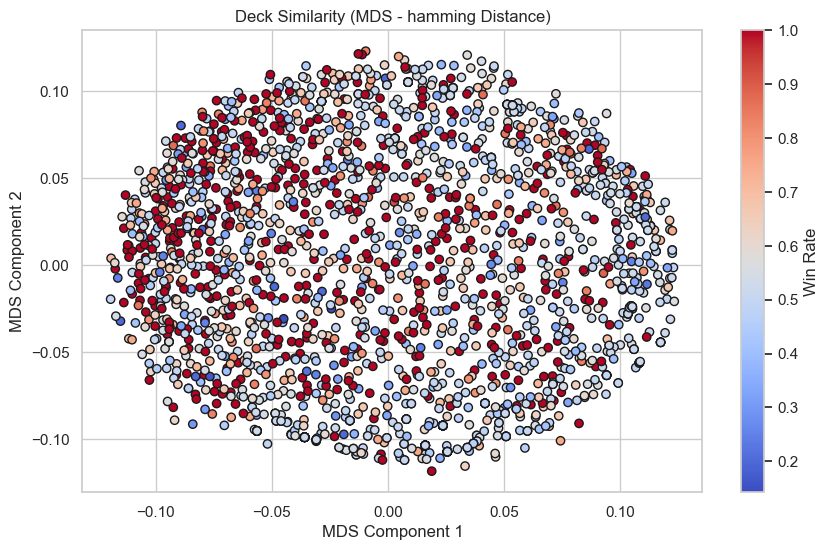

In [27]:
for metric in metrics:
    # ---- MDS Visualization ----
    plt.figure(figsize=(10, 6))
    sc = plt.scatter((plots_mds[metric])[:, 0], (plots_mds[metric])[:, 1], 
                     c=battles_df_sampled["winner.win_rate"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title(f"Deck Similarity (MDS - {metric} Distance)")
    plt.savefig(os.path.join(IMG_DIR, f"deck_similarity_mds_{metric}.png"), dpi=300)
    plt.show()

# FOR PAPER (Distance metrics)
Below, we present plots showing the results for the \textbf{Hamming}, \textbf{Euclidean}, \textbf{Canberra}, and \textbf{Cosine} distance metrics. Our primary objective is to quantify similarity between decks in a way that ensures meaningful separation, given our data representation. Each deck is represented as a binary vector of length equal to the total number of unique cards in the game, where a \textbf{1} appears at the index of each card present in the deck and a \textbf{0} otherwise.  

To evaluate similarity between decks, we considered the following metrics:  

\begin{enumerate}  
    \item \textbf{Hamming Distance} – This metric measures the number of positions where two binary vectors differ. In our case, it counts the number of cards that are different between two decks. Since our representation is binary and sparse, Hamming distance is an efficient and straightforward measure of deck dissimilarity. However, in our analysis, the MDS projection based on Hamming distance resulted in an irregular pattern, indicating that it may not be effective in distinguishing decks based on win rate.

    \item \textbf{Euclidean Distance} – This metric computes the straight-line distance between two points in high-dimensional space. Our results show that using Euclidean distance for MDS does not provide a well-structured separation between decks, as the data appears scattered rather than forming clear regions.

    \item \textbf{Canberra Distance} – This metric is useful for sparse binary data, as it emphasizes small differences more than other distance measures by computing the weighted difference between vector components:

    \begin{equation}  
        d(A, B) = \sum_{i} \frac{|A_i - B_i|}{|A_i| + |B_i|}
    \end{equation}  

    While theoretically beneficial for capturing subtle variations between decks, our analysis shows that the Canberra-based MDS projection does not produce a clear separation between win-rate levels, as the data remains widely dispersed without distinct clusters.

    \item \textbf{Cosine Distance} – This metric measures the angular difference between two vectors in high-dimensional space. It simplifies to computing the dot product. Our MDS results show that cosine distance provides the most interpretable separation, with high-win-rate decks forming a more compact and distinguishable region, albeit with some outliers. This suggests that cosine distance is the most effective metric for grouping decks based on win rate in our dataset from the metrics we tried out.
\end{enumerate}  


In [29]:
deck_positions_mds_hamming = plots_mds["hamming"]

Skipping non-numeric feature: winner.card_set
Skipping non-numeric feature: winner.tag
Skipping non-numeric feature: winner.cards.list


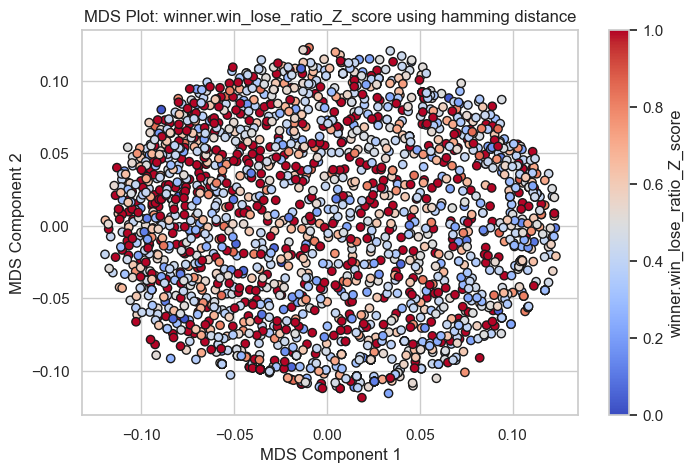

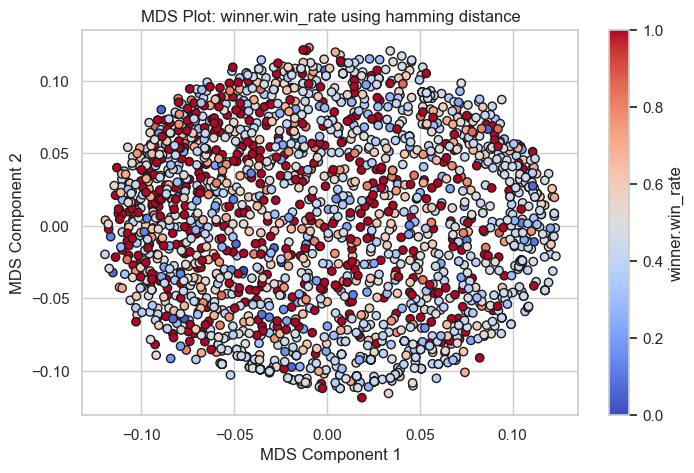

Skipping non-numeric feature: winner.deck_weighted_strength
Skipping non-numeric feature: winner.rarity_diversity
Skipping non-numeric feature: winner.synergy_score


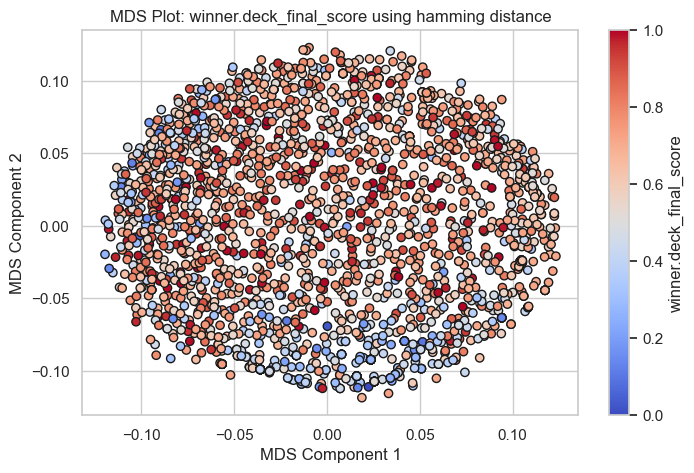

In [34]:
scaler = MinMaxScaler()
# metrics = ["hamming", "cosine"]
metrics = ["hamming"]
name_to_deck_positions_mapping = {
                                'hamming': deck_positions_mds_hamming, 
                                # 'cosine': deck_positions_mds_cosine
                                }
for feature in selected_features:
        if pd.api.types.is_numeric_dtype(battles_df_sampled[feature]) and feature in ["winner.win_rate", "winner.deck_final_score", "winner.win_lose_ratio_Z_score"]:
            feature_scaled = scaler.fit_transform(battles_df_sampled[feature].values.reshape(-1, 1))
            for metric in metrics:
                plt.figure(figsize=(8, 5))
                plt.scatter((name_to_deck_positions_mapping[metric])[:, 0], (name_to_deck_positions_mapping[metric])[:, 1], 
                            c=feature_scaled, cmap="coolwarm", edgecolors="k")
                plt.xlabel("MDS Component 1")
                plt.ylabel("MDS Component 2")
                plt.title(f"MDS Plot: {feature} using {metric} distance")
                cbar = plt.colorbar()
                cbar.set_label(feature)
                plt.savefig(os.path.join(IMG_DIR, f"mds_plot_{feature}_{metric}.png"), dpi=300)
                plt.show()
        else:
            print(f"Skipping non-numeric feature: {feature}")

# Interesting plots:
1. winner.win_lose_ratio_Z_score
2. winner.deck_weighted
3. winner.rarity_diversity
4. winner.deck_final_score
- In all of the plots above, we can see sort of inner red circles forming with the color red or even that the entire circle is red.

C:\Users\Saleh\AppData\Local\Temp\ipykernel_22960\1683303249.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mds.tight_layout(rect=[0, 0, 0.9, 1])


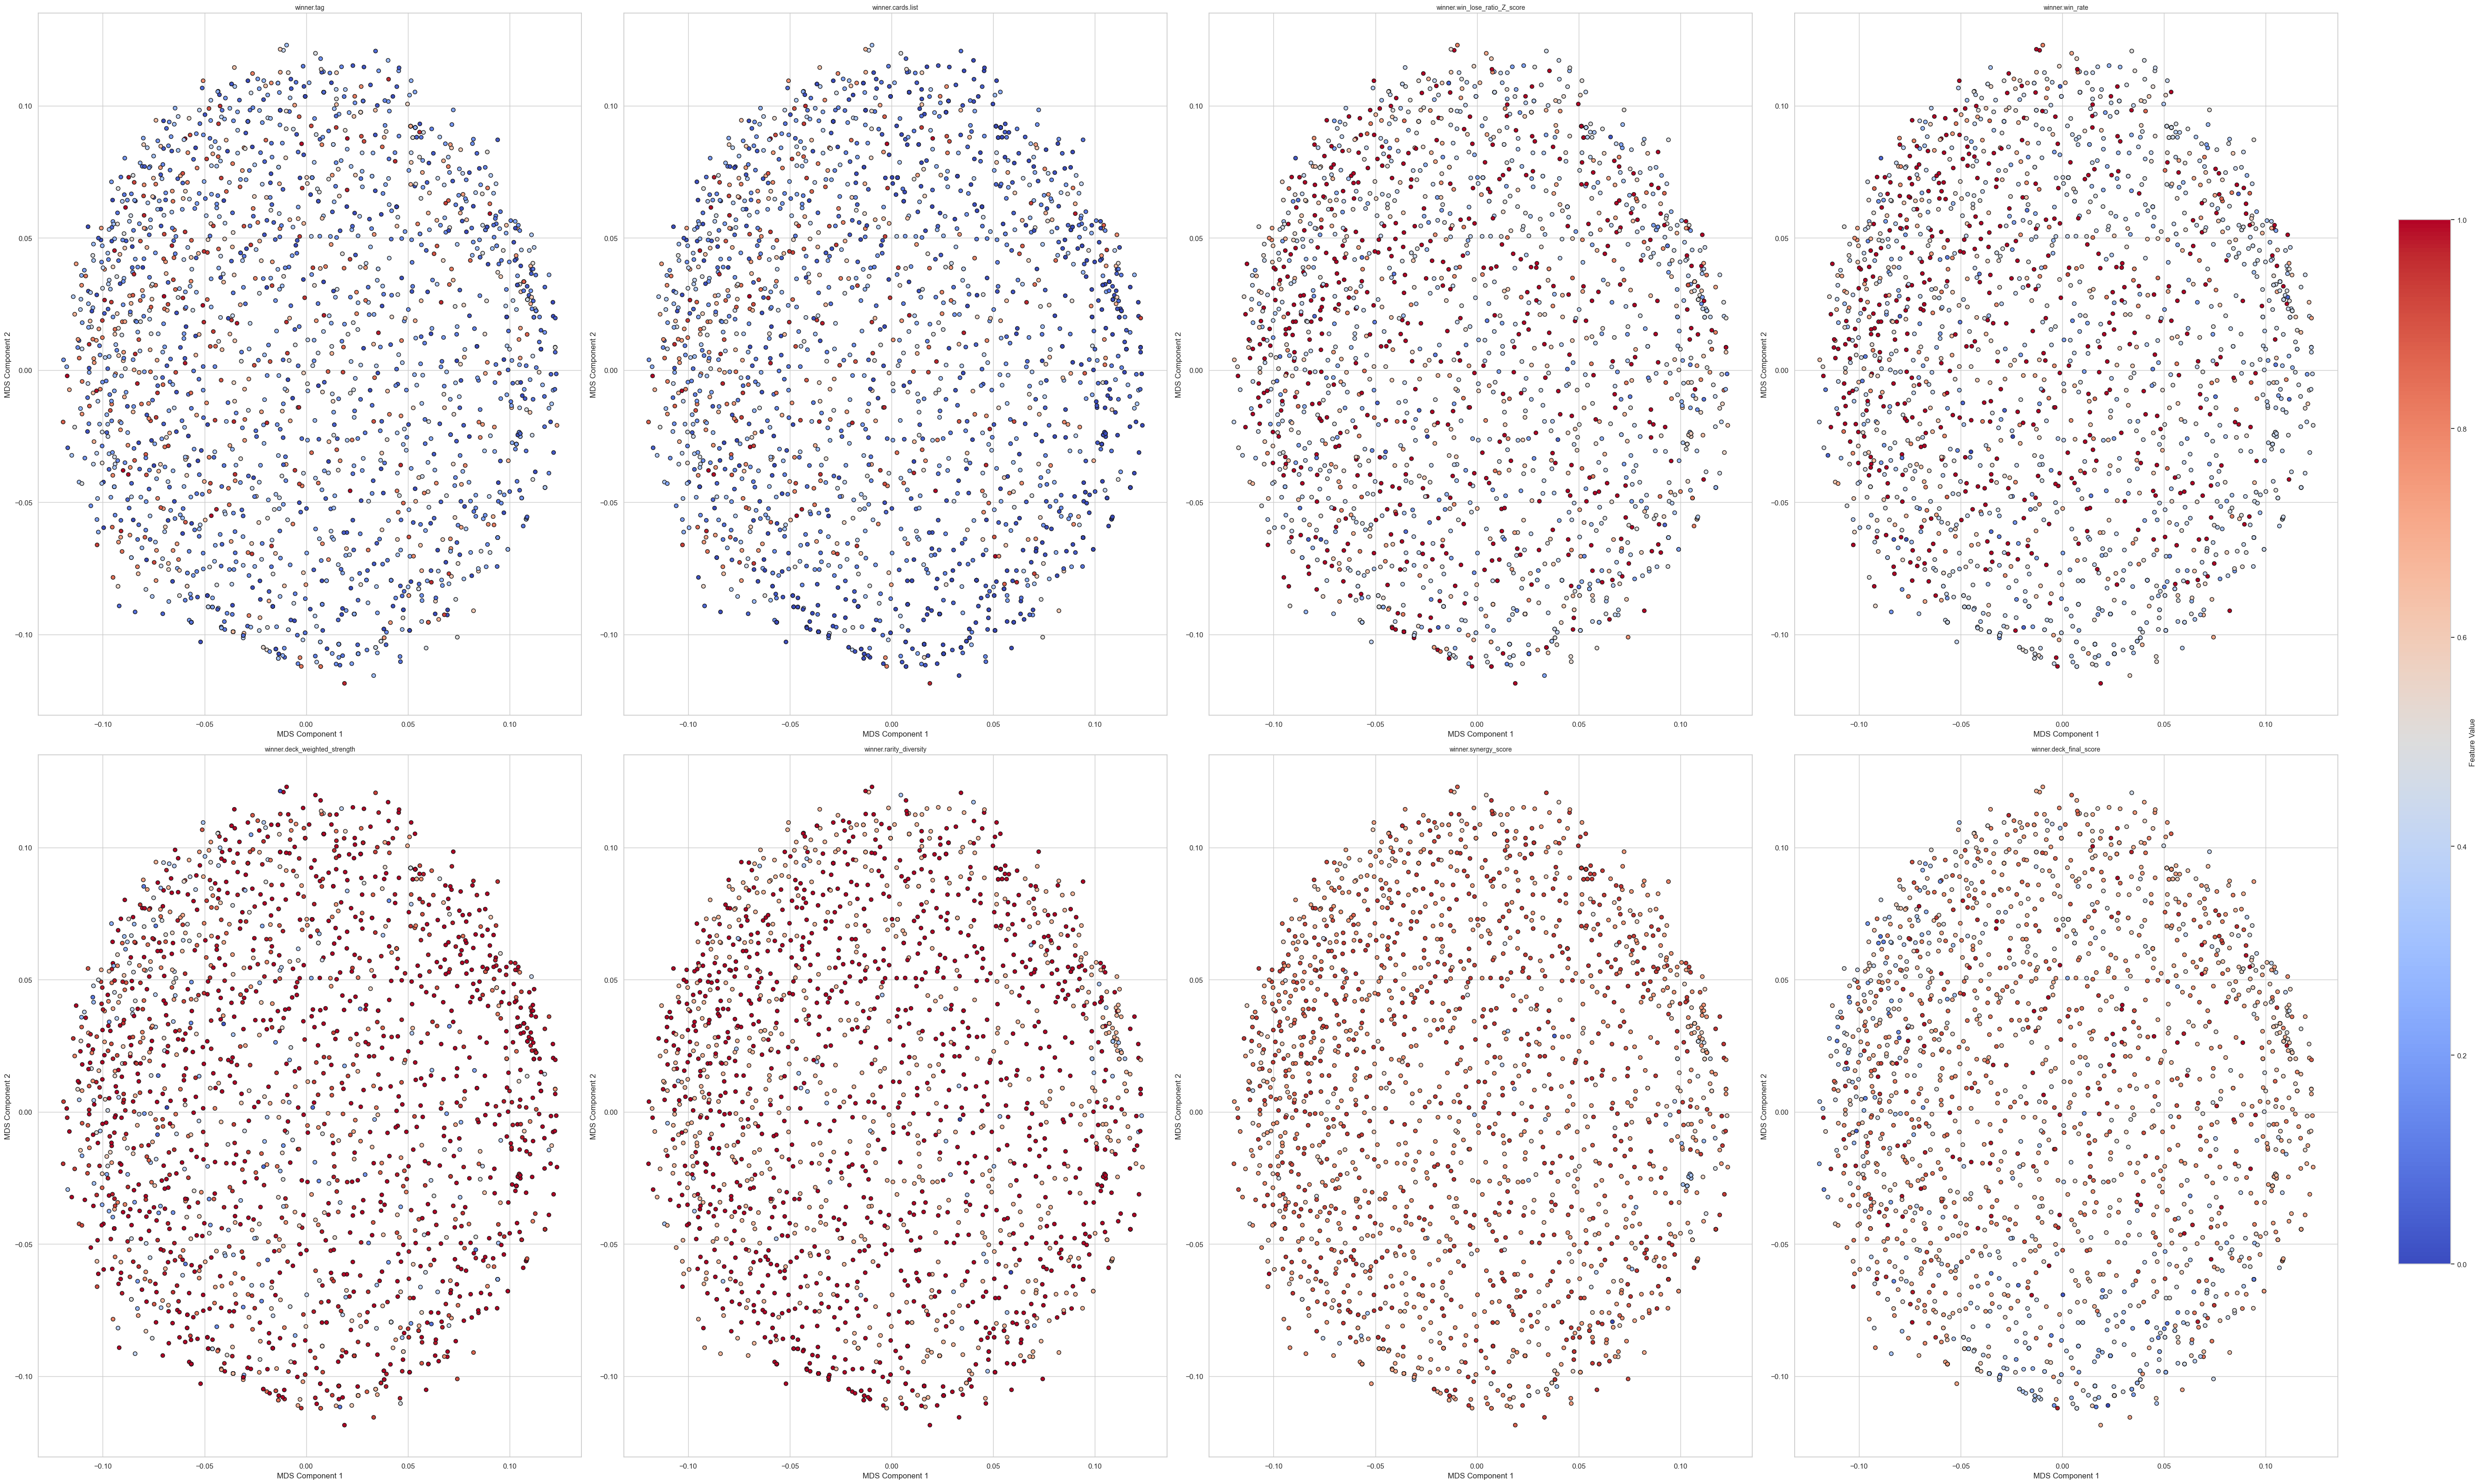

In [35]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

scaler = MinMaxScaler()

numeric_features = [f for f in selected_features if pd.api.types.is_numeric_dtype(battles_df_sampled[f])]
n_features = len(numeric_features)
n_cols = 4
n_rows = 2  

fig_mds, axes_mds = plt.subplots(n_rows, n_cols, figsize=(56, 32))

axes_mds = axes_mds.flatten()
sc_mds_first = None

for i, feature in enumerate(numeric_features):
    feature_scaled = scaler.fit_transform(battles_df_sampled[feature].values.reshape(-1, 1))

    # MDS Plot
    ax_mds = axes_mds[i]
    sc_mds = ax_mds.scatter(deck_positions_mds_hamming[:, 0], deck_positions_mds_hamming[:, 1], 
                            c=feature_scaled, cmap="coolwarm", edgecolors="k")
    ax_mds.set_xlabel("MDS Component 1")
    ax_mds.set_ylabel("MDS Component 2")
    ax_mds.set_title(f"{feature}", fontsize=10)

    if sc_mds_first is None:  
        sc_mds_first = sc_mds

for j in range(i + 1, len(axes_mds)):
    fig_mds.delaxes(axes_mds[j])

fig_mds.subplots_adjust(right=0.9)
cbar_ax_mds = fig_mds.add_axes([0.92, 0.15, 0.02, 0.7])
fig_mds.colorbar(sc_mds_first, cax=cbar_ax_mds, label="Feature Value")

fig_mds.tight_layout(rect=[0, 0, 0.9, 1])
fig_mds.savefig(os.path.join(IMG_DIR,"mds_plots.png"), dpi=300)

plt.show()


# TODO!
- reflect on the outcome of these plots.
- consider changing the sample size calculation to take into account the appearances of decks as to not be influenced by decks that appeared a low number of times?

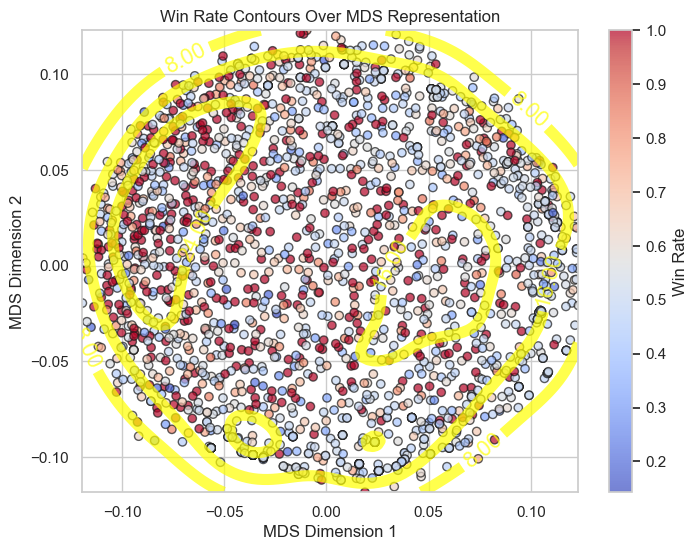

In [36]:
x, y = deck_positions_mds_hamming[:, 0], deck_positions_mds_hamming[:, 1]
win_rates = battles_df_sampled["winner.win_rate"].values

# Fit KDE using MDS coordinates and win_rate as weights
kde = gaussian_kde(np.vstack([x, y]), weights=win_rates)

# Create a grid over the MDS space
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
z_values = kde(positions).reshape(x_grid.shape)  # Evaluate KDE

# Plot scatter with color-coded win_rate
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=win_rates, cmap="coolwarm", edgecolors="k", alpha=0.7)
plt.colorbar(scatter, label="Win Rate")

# Add contour boundaries
contour = plt.contour(x_grid, y_grid, z_values, levels=3, colors='yellow', alpha=0.7, linewidths=8)
plt.clabel(contour, inline=True, fontsize=16, fmt="%.2f")

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Win Rate Contours Over MDS Representation")
plt.show()


# Notes about the plot
1. we can see 3 different borders, the inner we go the higher the win rate (redder)
2. we have 3 different level, "high win rate", "medium win rate", "low win rate".
3. we can sort of seea hierarchical approach to classify points into each level.
4. when handling new data, we could see which cnotour it belongs to and try to predict its winning rate accorngly (maybe take the median of the contour)

# Explanation about KDE
KDE is a statistical method used to estimate the probability density function of a dataset. It smooths out a scatter plot by computing how dense the points are at different locations.

Think of KDE as spreading each data point like a small hill. When we sum up all these hills, we get a smooth surface that represents density.

In [37]:
# from sklearn.cluster import KMeans

# features = battles_df_ext.columns[1:-1]

# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(battles_df_ext[features])

# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(normalized_features)

# battles_df_ext["cluster_kmeans"] = clusters
# cluster_summary_kmeans = battles_df_ext.groupby("cluster_kmeans")["win_rate_scaled"].mean()

# plt.figure(figsize=(10, 6))
# plt.scatter(battles_df_ext[features[0]], battles_df_ext[features[1]], c=battles_df_ext["cluster_kmeans"], cmap="coolwarm", edgecolors="k")
# plt.xlabel(features[0])
# plt.ylabel(features[1])
# plt.title("K-Means")
# plt.colorbar(label="Cluster")
# plt.show()

# for i in range(len(features)):
#     for j in range(i + 1, len(features)):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(battles_df_ext[features[i]], battles_df_ext[features[j]], c=battles_df_ext["cluster_kmeans"], cmap="coolwarm", edgecolors="k")
#         plt.xlabel(features[i])
#         plt.ylabel(features[j])
#         plt.title(f"K-Means: {features[i]} vs {features[j]}")
#         plt.colorbar(label="Cluster")
#         plt.show()